In [1]:
import numpy as np
import torch as th
import os
%load_ext autoreload
%autoreload 2
from PIL import Image 
from IPython.display import clear_output
from matplotlib.pyplot import imshow 
import matplotlib.pyplot as plt
import PIL
import torch

from itertools import islice
from torchvision.transforms.functional import to_tensor

import pandas as pd
from torchvision import transforms
from itertools import product
%matplotlib inline

# Add path to project 

In [2]:
import sys
sys.path
sys.path.append('/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/')

In [3]:
from util_files.rendering.cairo  import render,render_with_skeleton
from util_files.data.graphics_primitives import PT_LINE,  PT_CBEZIER, PT_QBEZIER
import  util_files.loss_functions.supervised  as supervised_loss 
from util_files.optimization.optimizer.scheduled_optimizer import ScheduledOptimizer
import util_files.dataloading as dataloading
from vectorization import load_model
from util_files.patchify import patchify
from util_files.geometric import liang_barsky_screen
from util_files.rendering.cairo import render

/home/vage/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Parameters

In [4]:
device = torch.device('cuda:{}'.format(0))
prefetch_data = True
batches_completed_in_epoch=0
epoch_size = 20000
curve_count = 10
model_type = "model"

In [5]:
import sys; sys.argv=['']; del sys
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--output_dir', type=str, default="/home/vage/Downloads/testing_line/", help='dir to folder for output')
    parser.add_argument('--diff_render_it', type=int, default=200, help='iteration count')
    parser.add_argument('--init_random', action='store_true', default=False, dest='init_random',
                        help='init model with random [default: False].')
    parser.add_argument('--rendering_type', type=str, default='hard', help='hard -oleg,simple Alexey')
    parser.add_argument('--data_dir', type=str, default="/home/vage/Downloads/abc/", help='dir to folder for input')
    parser.add_argument('--image_name', type=str, default="00050000_99fd5beca7714bc586260b6a_step_000.png",
                        help='Name of image.If None will perform to all images in '
                             'folder.[default: None]')
    parser.add_argument('--overlap', type=int, default=0, help='overlap in pixel')
    parser.add_argument('--model_output_count', type=int, default=10, help='max_model_output')
    
    return parser.parse_args()

In [6]:
options = parse_args()

# Read image/dataset

In [7]:
def preprocess_image(image):
    patch_height, patch_width = image.shape[1:3]
    image = torch.as_tensor(image).type(torch.float32).reshape(-1, patch_height, patch_width) / 255
    image = 1 - image  # 0 -- background
    mask = (image > 0).type(torch.float32)
    _xs = np.arange(1, patch_width + 1, dtype=np.float32)[None].repeat(patch_height, 0) / patch_width
    _ys = np.arange(1, patch_height + 1, dtype=np.float32)[..., None].repeat(patch_width, 1) / patch_height
    _xs = torch.from_numpy(_xs)[None]
    _ys = torch.from_numpy(_ys)[None]
    return torch.stack([image, _xs * mask, _ys * mask], dim=1)

In [8]:
def read_data(options, image_type = 'RGB'):
    train_transform = transforms.Compose([
        # something wrong with current model in vertical lines add random rotate if you need results too be better
#         transforms.RandomRotation(degrees = (2,5),fill=255),
        transforms.ToTensor(),
    ])
    dataset = []
    if options.image_name is None:
        image_names = os.listdir(options.data_dir)
        print(image_names)
        for image_name in image_names:
            if (image_name[-4:] != 'jpeg' and image_name[-3:] != 'png' and image_name[-3:] != 'jpg') or image_name[0]=='.':
                print(image_name[-4:])
                continue
            
            img = train_transform(Image.open(options.data_dir + image_name).convert(image_type))
            print(img.shape)
            img_t = torch.ones(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                               img.shape[2] + (32 - img.shape[2] % 32))
            img_t[:, :img.shape[1], :img.shape[2]] = img
            dataset.append(img_t)
        options.image_name = image_names
    else:
        img = train_transform(Image.open(options.data_dir + options.image_name).convert(image_type))
        print(img)
        print(img.shape)
        img_t = torch.ones(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                           img.shape[2] + (32 - img.shape[2] % 32))
        img_t[:, :img.shape[1], :img.shape[2]] = img
        dataset.append(img_t)
        options.image_name = [options.image_name]

    return dataset

In [9]:
# options.image_name = options.image_name[0]
images = read_data(options,image_type='L')

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
torch.Size([1, 2220, 2652])


In [10]:
images[0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [11]:
image = images[0]

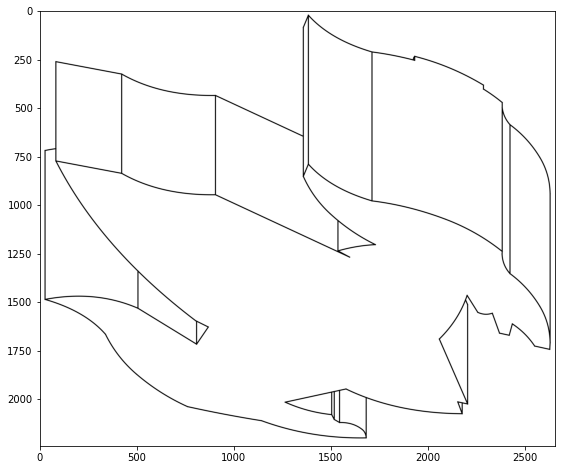

In [12]:
plt.figure(figsize=(12,8))
plt.imshow(image[0],'gray')

In [13]:
image

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

# Model loading 

In [14]:
# in json file you can chose model type and it's parameters as in examples in vectorization/models/specs/ folder

In [15]:
# chose json file 
model_json_param = '/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/vectorization/models/specs/resnet18_blocks1_bn_64__c2h__trans_heads4_feat256_blocks8_ffmaps512__h2o__out512.json'
#load/create model 
model = load_model(model_json_param).to(device)

In [16]:
def serialize(checkpoint):
    model_state_dict = checkpoint['model_state_dict']
    keys = []
    for k in model_state_dict:
        if 'hidden.transformer' in k:
            keys.append(k)

    for k in keys:
        new_key = 'hidden.decoder.transformer' + k[len('hidden.transformer'):]
        model_state_dict[new_key] = model_state_dict[k]
        del model_state_dict[k]
    return checkpoint
checkpoint = serialize(torch.load("/home/vage/Downloads/02.03_safin/29.02_abc/model_curves.weights"))


model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Estimation of primitive 

In [17]:
def split_to_patches(rgb, patch_size, overlap=0):
    """Separates the input into square patches of specified size.

    :param rgb: input RGB image
    :type rgb: numpy.ndarray
    :param patch_size: size of patches in pixels (assuming
                        square patches)
    :type patch_size: int
    :param overlap: amount in pixels of how much the patches
                    can overlap with each other (useful for merging)
    :type overlap: int

    :returns patches, patches_offsets
    :rtype Tuple[numpy.ndarray, numpy.ndarray]
    """
    rgb = rgb.transpose(1, 2, 0)
    rgb_t = np.ones((rgb.shape[0] + 33, rgb.shape[1] + 33, rgb.shape[2])) * 255.
    rgb_t[:rgb.shape[0], :rgb.shape[1], :] = rgb
    rgb = rgb_t

    height, width, channels = rgb.shape

    assert patch_size > 0 and 0 <= overlap < patch_size
    patches = patchify(rgb,
                       patch_size=(patch_size, patch_size, channels),
                       step=patch_size - overlap)
    patches = patches.reshape((-1, patch_size, patch_size, channels))
    height_offsets = np.arange(0, height - patch_size, step=patch_size - overlap)
    width_offsets = np.arange(0, width - patch_size, step=patch_size - overlap)
    patches_offsets = np.array(list(
        product(height_offsets, width_offsets)
    ))
    return patches, patches_offsets, rgb

In [18]:
image_tensor = image.unsqueeze(0).to(device)
patches_rgb, patches_offsets, input_rgb = split_to_patches(image_tensor.cpu().numpy()[0] * 255, 64, options.overlap)

In [19]:
model.eval()
patches_vector = []
print('--- Preprocessing BEGIN')
patch_images = preprocess_image(patches_rgb)
print('--- Preprocessing END')

for it_batches in range(400, patch_images.shape[0] + 399, 400):
    it_start = it_batches - 400
    if it_batches > patch_images.shape[0]:
        it_batches = patch_images.shape[0]
    with torch.no_grad():
        if(it_start==0):
            patches_vector = model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()
        else:
            patches_vector = np.concatenate((patches_vector,model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()),axis=0)
patches_vector = torch.tensor(patches_vector) * 64

--- Preprocessing BEGIN
--- Preprocessing END


In [20]:
patches_vector.shape

torch.Size([1470, 10, 8])

In [21]:
a ={PT_QBEZIER:patches_vector[200]}
rendered_image = render(a,(64,64), data_representation='vahe',linecaps='round')

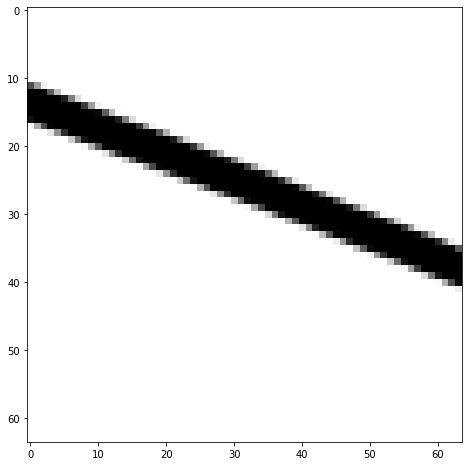

In [22]:
plt.figure(figsize=(12,8))
plt.imshow(rendered_image,"gray")

In [23]:
def assemble_vector_patches(patches_vector, patches_offsets):
    primitives = []
    i = 0
    for patch_vector, patch_offset in zip(patches_vector, patches_offsets):
        i += 1
        
        patch_vector[:, [0, 2, 4]] += patch_offset[1]
        

        patch_vector[:, [1, 3, 5]] += patch_offset[0]
        primitives.append(patch_vector)
    return np.array(primitives)


In [24]:
vect = assemble_vector_patches(np.array((patches_vector.reshape(-1, options.model_output_count, 8))),
                                   np.array(patches_offsets))
vect = vect.reshape(-1,8)
vect = vect[(vect[:, -2] > 0.3)]
vect = vect[(vect[:, -1] > 0.5)]

In [25]:
a ={PT_QBEZIER:vect}
rendered_image = render(a,(image.shape[2],(image.shape[1])), data_representation='vahe',linecaps='round')

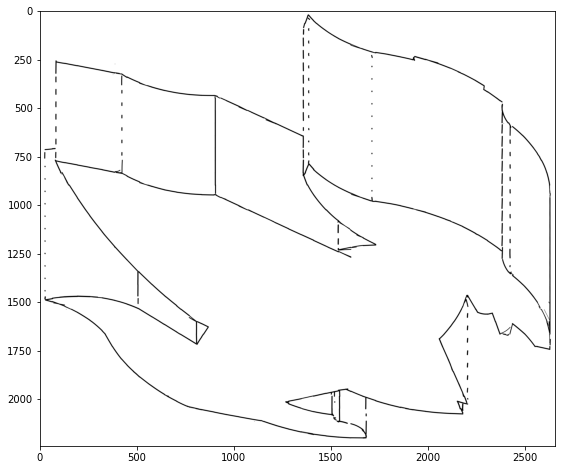

In [26]:
plt.figure(figsize=(12,8))
plt.imshow(rendered_image,"gray")

For some reson model failing to correctly predict vertical lines. One way to correct it, is to slighlty rotate image, another one is to retrain model or refine it on vertical lines.  
P.s. In the paper, all metrics was estimated with this bug, so correcting it may lead to better results.

# Refinement

In [29]:
control_points_n=3
dtype=torch.float32
intermediate_output ={'options':options,'patches_offsets':patches_offsets,
                      'patches_vector':patches_vector,
                      'cleaned_image_shape':(rendered_image.shape[0],rendered_image.shape[1]),
                     'patches_rgb':patches_rgb}


In [30]:
import os
import pickle
import sys
from time import time

import h5py
import numpy as np
import torch
from tqdm import trange


from util_files.optimization.optimizer.logging import Logger
from util_files.evaluation_utils import vector_image_from_patches

from util_files.optimization.optimizer.adam import Adam
from util_files.optimization.primitives.line_tensor import LineTensor
from util_files.optimization.primitives.quadratic_bezier_tensor import QuadraticBezierTensor
from util_files.optimization.parameters import min_linear_size
from util_files.simplification.join_qb import join_quad_beziers
from refinement.our_refinment.refinement_for_curves import main as curve_refinement

In [31]:
primitives_after_optimization, patch__optim_offsets,repatch_scale, optim_vector_image = curve_refinement(options,intermediate_output,optimization_iters_n=400)

2021-04-06 19:18:17,735 INFO: 1. Load intermediate output from /home/vage/Downloads/testing_line//intermediate_output/00050000_99fd5beca7714bc586260b6a_step_000.pickle
2021-04-06 19:18:17,740 INFO: 2.5. Repatch
2021-04-06 19:18:17,742 INFO: 	the width is 5.658815383911133
2021-04-06 19:18:17,742 INFO: 	the width percentile is 90
2021-04-06 19:18:17,743 INFO: 	repatch scale is 3
2021-04-06 19:18:22,635 INFO: 	168 patches left with max 10 primitives per patch
2021-04-06 19:18:22,636 INFO: 3. Filter out empty patches
2021-04-06 19:18:22,636 INFO: 	from 168 patches
2021-04-06 19:18:22,637 INFO: 	94 patches left
2021-04-06 19:18:22,638 INFO: 3.5. Sort patches
2021-04-06 19:18:22,639 INFO: 	94 patches left with max 10 primitives per patch
2021-04-06 19:18:22,640 INFO: 6. Optimization parameters
2021-04-06 19:18:22,640 INFO: 	primitive type is qbeziers
2021-04-06 19:18:22,640 INFO: 	primitive type of model outputs is qbeziers
2021-04-06 19:18:22,640 INFO: 	initialization is model
2021-04-06 1

2021-04-06 19:18:30,537 INFO: 	optimize patches 0-31:  66%|######6   | 265/400 [00:07<00:04, 31.07it/s]
2021-04-06 19:18:30,674 INFO: 	optimize patches 0-31:  67%|######7   | 269/400 [00:08<00:04, 30.46it/s]
2021-04-06 19:18:30,793 INFO: 	optimize patches 0-31:  68%|######8   | 273/400 [00:08<00:04, 31.34it/s]
2021-04-06 19:18:30,917 INFO: 	optimize patches 0-31:  70%|######9   | 278/400 [00:08<00:03, 33.60it/s]
2021-04-06 19:18:31,023 INFO: 	optimize patches 0-31:  70%|#######   | 282/400 [00:08<00:03, 34.70it/s]
2021-04-06 19:18:31,128 INFO: 	optimize patches 0-31:  72%|#######1  | 286/400 [00:08<00:03, 35.74it/s]
2021-04-06 19:18:31,229 INFO: 	optimize patches 0-31:  72%|#######2  | 290/400 [00:08<00:02, 36.74it/s]
2021-04-06 19:18:31,332 INFO: 	optimize patches 0-31:  74%|#######3  | 294/400 [00:08<00:02, 37.36it/s]
2021-04-06 19:18:31,434 INFO: 	optimize patches 0-31:  74%|#######4  | 298/400 [00:08<00:02, 37.88it/s]
2021-04-06 19:18:31,557 INFO: 	optimize patches 0-31:  76%|#####

2021-04-06 19:18:39,451 INFO: 	optimize patches 32-46:  42%|####1     | 166/400 [00:05<00:08, 28.52it/s]
2021-04-06 19:18:39,562 INFO: 	optimize patches 32-46:  42%|####2     | 170/400 [00:05<00:07, 30.40it/s]
2021-04-06 19:18:39,672 INFO: 	optimize patches 32-46:  44%|####3     | 174/400 [00:05<00:07, 32.02it/s]
2021-04-06 19:18:39,782 INFO: 	optimize patches 32-46:  44%|####4     | 178/400 [00:05<00:06, 33.22it/s]
2021-04-06 19:18:39,953 INFO: 	optimize patches 32-46:  46%|####5     | 182/400 [00:05<00:07, 29.45it/s]
2021-04-06 19:18:40,066 INFO: 	optimize patches 32-46:  46%|####6     | 186/400 [00:05<00:06, 31.06it/s]
2021-04-06 19:18:40,172 INFO: 	optimize patches 32-46:  48%|####7     | 190/400 [00:06<00:06, 32.76it/s]
2021-04-06 19:18:40,282 INFO: 	optimize patches 32-46:  48%|####8     | 194/400 [00:06<00:06, 33.80it/s]
2021-04-06 19:18:40,393 INFO: 	optimize patches 32-46:  50%|####9     | 198/400 [00:06<00:05, 34.44it/s]
2021-04-06 19:18:40,536 INFO: 	optimize patches 32-46: 

2021-04-06 19:18:48,491 INFO: 	optimize patches 47-57:  15%|#5        | 61/400 [00:01<00:13, 25.65it/s]
2021-04-06 19:18:48,591 INFO: 	optimize patches 47-57:  16%|#6        | 64/400 [00:02<00:12, 26.79it/s]
2021-04-06 19:18:48,700 INFO: 	optimize patches 47-57:  17%|#6        | 67/400 [00:02<00:12, 27.02it/s]
2021-04-06 19:18:48,832 INFO: 	optimize patches 47-57:  18%|#7        | 71/400 [00:02<00:11, 27.93it/s]
2021-04-06 19:18:48,965 INFO: 	optimize patches 47-57:  19%|#8        | 75/400 [00:02<00:11, 28.55it/s]
2021-04-06 19:18:49,094 INFO: 	optimize patches 47-57:  20%|#9        | 79/400 [00:02<00:10, 29.24it/s]
2021-04-06 19:18:49,209 INFO: 	optimize patches 47-57:  20%|##        | 82/400 [00:02<00:11, 28.25it/s]
2021-04-06 19:18:49,334 INFO: 	optimize patches 47-57:  22%|##1       | 86/400 [00:02<00:10, 29.24it/s]
2021-04-06 19:18:49,451 INFO: 	optimize patches 47-57:  22%|##2       | 90/400 [00:02<00:10, 30.60it/s]
2021-04-06 19:18:49,591 INFO: 	optimize patches 47-57:  24%|##3 

2021-04-06 19:18:58,547 INFO: 	optimize patches 47-57:  93%|#########2| 371/400 [00:12<00:00, 30.96it/s]
2021-04-06 19:18:58,661 INFO: 	optimize patches 47-57:  94%|#########3| 375/400 [00:12<00:00, 32.13it/s]
2021-04-06 19:18:58,772 INFO: 	optimize patches 47-57:  95%|#########4| 379/400 [00:12<00:00, 33.19it/s]
2021-04-06 19:18:58,891 INFO: 	optimize patches 47-57:  96%|#########5| 383/400 [00:12<00:00, 33.34it/s]
2021-04-06 19:18:59,007 INFO: 	optimize patches 47-57:  97%|#########6| 387/400 [00:12<00:00, 33.60it/s]
2021-04-06 19:18:59,129 INFO: 	optimize patches 47-57:  98%|#########7| 391/400 [00:12<00:00, 33.43it/s]
2021-04-06 19:18:59,238 INFO: 	optimize patches 47-57:  99%|#########8| 395/400 [00:12<00:00, 34.28it/s]
2021-04-06 19:18:59,348 INFO: 	optimize patches 47-57: 100%|#########9| 399/400 [00:12<00:00, 34.89it/s]
2021-04-06 19:18:59,376 INFO: 	optimize patches 47-57: 100%|##########| 400/400 [00:12<00:00, 31.08it/s]
2021-04-06 19:18:59,377 INFO: Optimize batches:  33%|##

2021-04-06 19:19:08,645 INFO: 	optimize patches 58-69:  50%|#####     | 200/400 [00:09<00:11, 18.06it/s]
2021-04-06 19:19:08,757 INFO: 	optimize patches 58-69:  50%|#####     | 202/400 [00:09<00:10, 18.01it/s]
2021-04-06 19:19:08,869 INFO: 	optimize patches 58-69:  51%|#####1    | 205/400 [00:09<00:09, 19.95it/s]
2021-04-06 19:19:08,986 INFO: 	optimize patches 58-69:  52%|#####2    | 208/400 [00:09<00:08, 21.39it/s]
2021-04-06 19:19:09,100 INFO: 	optimize patches 58-69:  53%|#####2    | 211/400 [00:09<00:08, 22.68it/s]
2021-04-06 19:19:09,212 INFO: 	optimize patches 58-69:  54%|#####3    | 214/400 [00:09<00:07, 23.73it/s]
2021-04-06 19:19:09,325 INFO: 	optimize patches 58-69:  54%|#####4    | 217/400 [00:09<00:07, 24.53it/s]
2021-04-06 19:19:09,480 INFO: 	optimize patches 58-69:  55%|#####5    | 220/400 [00:10<00:07, 22.70it/s]
2021-04-06 19:19:09,668 INFO: 	optimize patches 58-69:  56%|#####5    | 223/400 [00:10<00:08, 20.17it/s]
2021-04-06 19:19:09,783 INFO: 	optimize patches 58-69: 

2021-04-06 19:19:18,142 INFO: 	optimize patches 70-76:   7%|7         | 29/400 [00:01<00:17, 21.48it/s]
2021-04-06 19:19:18,257 INFO: 	optimize patches 70-76:   8%|8         | 33/400 [00:01<00:15, 24.26it/s]
2021-04-06 19:19:18,380 INFO: 	optimize patches 70-76:   9%|9         | 37/400 [00:01<00:13, 26.26it/s]
2021-04-06 19:19:18,508 INFO: 	optimize patches 70-76:  10%|#         | 41/400 [00:01<00:13, 27.57it/s]
2021-04-06 19:19:18,623 INFO: 	optimize patches 70-76:  11%|#1        | 45/400 [00:01<00:12, 29.41it/s]
2021-04-06 19:19:18,737 INFO: 	optimize patches 70-76:  12%|#2        | 49/400 [00:01<00:11, 30.87it/s]
2021-04-06 19:19:18,855 INFO: 	optimize patches 70-76:  13%|#3        | 53/400 [00:01<00:10, 31.76it/s]
2021-04-06 19:19:18,974 INFO: 	optimize patches 70-76:  14%|#4        | 57/400 [00:01<00:10, 32.30it/s]
2021-04-06 19:19:19,306 INFO: 	optimize patches 70-76:  15%|#5        | 61/400 [00:02<00:15, 21.45it/s]
2021-04-06 19:19:19,429 INFO: 	optimize patches 70-76:  16%|#6  

2021-04-06 19:19:28,628 INFO: 	optimize patches 70-76:  85%|########5 | 341/400 [00:11<00:01, 34.18it/s]
2021-04-06 19:19:28,743 INFO: 	optimize patches 70-76:  86%|########6 | 345/400 [00:11<00:01, 34.41it/s]
2021-04-06 19:19:28,856 INFO: 	optimize patches 70-76:  87%|########7 | 349/400 [00:11<00:01, 34.69it/s]
2021-04-06 19:19:28,968 INFO: 	optimize patches 70-76:  88%|########8 | 353/400 [00:11<00:01, 34.95it/s]
2021-04-06 19:19:29,080 INFO: 	optimize patches 70-76:  89%|########9 | 357/400 [00:12<00:01, 35.19it/s]
2021-04-06 19:19:29,374 INFO: 	optimize patches 70-76:  90%|######### | 361/400 [00:12<00:01, 23.85it/s]
2021-04-06 19:19:29,493 INFO: 	optimize patches 70-76:  91%|#########1| 365/400 [00:12<00:01, 26.10it/s]
2021-04-06 19:19:29,618 INFO: 	optimize patches 70-76:  92%|#########2| 369/400 [00:12<00:01, 27.66it/s]
2021-04-06 19:19:29,740 INFO: 	optimize patches 70-76:  93%|#########3| 373/400 [00:12<00:00, 29.04it/s]
2021-04-06 19:19:29,858 INFO: 	optimize patches 70-76: 

2021-04-06 19:19:38,977 INFO: 	optimize patches 77-85:  46%|####6     | 184/400 [00:08<00:13, 16.61it/s]
2021-04-06 19:19:39,103 INFO: 	optimize patches 77-85:  47%|####6     | 187/400 [00:08<00:11, 18.26it/s]
2021-04-06 19:19:39,224 INFO: 	optimize patches 77-85:  48%|####7     | 190/400 [00:08<00:10, 19.82it/s]
2021-04-06 19:19:39,348 INFO: 	optimize patches 77-85:  48%|####8     | 193/400 [00:08<00:09, 20.95it/s]
2021-04-06 19:19:39,470 INFO: 	optimize patches 77-85:  49%|####9     | 196/400 [00:08<00:09, 21.91it/s]
2021-04-06 19:19:39,592 INFO: 	optimize patches 77-85:  50%|####9     | 199/400 [00:09<00:08, 22.68it/s]
2021-04-06 19:19:39,724 INFO: 	optimize patches 77-85:  50%|#####     | 202/400 [00:09<00:08, 22.69it/s]
2021-04-06 19:19:39,848 INFO: 	optimize patches 77-85:  51%|#####1    | 205/400 [00:09<00:08, 23.13it/s]
2021-04-06 19:19:39,967 INFO: 	optimize patches 77-85:  52%|#####2    | 208/400 [00:09<00:08, 23.69it/s]
2021-04-06 19:19:40,092 INFO: 	optimize patches 77-85: 

2021-04-06 19:19:49,023 INFO: 	optimize patches 86-90:   2%|2         | 9/400 [00:00<00:47,  8.26it/s]
2021-04-06 19:19:49,140 INFO: 	optimize patches 86-90:   3%|3         | 13/400 [00:00<00:36, 10.69it/s]
2021-04-06 19:19:49,254 INFO: 	optimize patches 86-90:   4%|4         | 17/400 [00:00<00:28, 13.51it/s]
2021-04-06 19:19:49,377 INFO: 	optimize patches 86-90:   5%|5         | 21/400 [00:00<00:23, 16.37it/s]
2021-04-06 19:19:49,494 INFO: 	optimize patches 86-90:   6%|6         | 25/400 [00:00<00:19, 19.42it/s]
2021-04-06 19:19:49,612 INFO: 	optimize patches 86-90:   7%|7         | 29/400 [00:01<00:16, 22.25it/s]
2021-04-06 19:19:49,729 INFO: 	optimize patches 86-90:   8%|8         | 33/400 [00:01<00:14, 24.86it/s]
2021-04-06 19:19:49,843 INFO: 	optimize patches 86-90:   9%|9         | 37/400 [00:01<00:13, 27.25it/s]
2021-04-06 19:19:49,965 INFO: 	optimize patches 86-90:  10%|#         | 41/400 [00:01<00:12, 28.69it/s]
2021-04-06 19:19:50,083 INFO: 	optimize patches 86-90:  11%|#1   

2021-04-06 19:19:59,496 INFO: 	optimize patches 86-90:  81%|########1 | 325/400 [00:10<00:02, 31.81it/s]
2021-04-06 19:19:59,613 INFO: 	optimize patches 86-90:  82%|########2 | 329/400 [00:11<00:02, 32.50it/s]
2021-04-06 19:19:59,735 INFO: 	optimize patches 86-90:  83%|########3 | 333/400 [00:11<00:02, 32.52it/s]
2021-04-06 19:19:59,852 INFO: 	optimize patches 86-90:  84%|########4 | 337/400 [00:11<00:01, 32.99it/s]
2021-04-06 19:19:59,974 INFO: 	optimize patches 86-90:  85%|########5 | 341/400 [00:11<00:01, 32.95it/s]
2021-04-06 19:20:00,091 INFO: 	optimize patches 86-90:  86%|########6 | 345/400 [00:11<00:01, 33.38it/s]
2021-04-06 19:20:00,206 INFO: 	optimize patches 86-90:  87%|########7 | 349/400 [00:11<00:01, 33.74it/s]
2021-04-06 19:20:00,325 INFO: 	optimize patches 86-90:  88%|########8 | 353/400 [00:11<00:01, 33.74it/s]
2021-04-06 19:20:00,446 INFO: 	optimize patches 86-90:  89%|########9 | 357/400 [00:11<00:01, 33.47it/s]
2021-04-06 19:20:00,757 INFO: 	optimize patches 86-90: 

2021-04-06 19:20:08,909 INFO: 	optimize patches 91-92:  84%|########4 | 338/400 [00:06<00:01, 54.39it/s]
2021-04-06 19:20:09,016 INFO: 	optimize patches 91-92:  86%|########6 | 344/400 [00:07<00:01, 54.97it/s]
2021-04-06 19:20:09,120 INFO: 	optimize patches 91-92:  88%|########7 | 350/400 [00:07<00:00, 55.79it/s]
2021-04-06 19:20:09,225 INFO: 	optimize patches 91-92:  89%|########9 | 356/400 [00:07<00:00, 56.19it/s]
2021-04-06 19:20:09,409 INFO: 	optimize patches 91-92:  90%|######### | 362/400 [00:07<00:00, 46.12it/s]
2021-04-06 19:20:09,513 INFO: 	optimize patches 91-92:  92%|#########2| 368/400 [00:07<00:00, 49.11it/s]
2021-04-06 19:20:09,617 INFO: 	optimize patches 91-92:  94%|#########3| 374/400 [00:07<00:00, 51.42it/s]
2021-04-06 19:20:09,720 INFO: 	optimize patches 91-92:  95%|#########5| 380/400 [00:07<00:00, 53.19it/s]
2021-04-06 19:20:09,829 INFO: 	optimize patches 91-92:  96%|#########6| 386/400 [00:07<00:00, 53.86it/s]
2021-04-06 19:20:09,934 INFO: 	optimize patches 91-92: 

/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/util_files/evaluation_utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  primitives = torch.tensor(primitives)
/home/vage/PycharmProjects/Deep-Vectorization-of-Technical-Drawings/util_files/evaluation_utils.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch_offsets = torch.tensor(patch_offsets).type(dtype)


{'width': '2656px', 'height': '2240px', 'viewBox': '0 0 2656 2240', 'size': ('2656px', '2240px')}


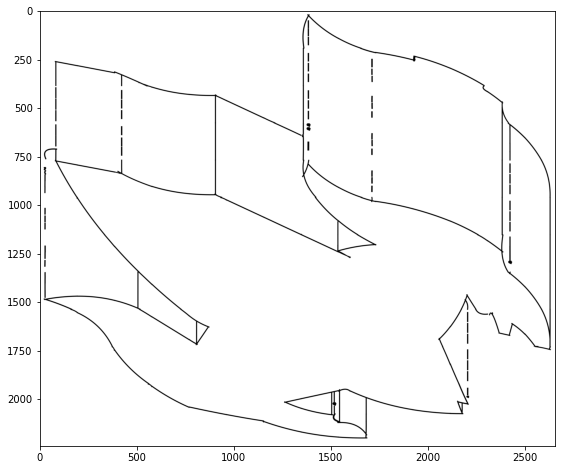

In [32]:
plt.figure(figsize=(12,8))
plt.imshow(optim_vector_image.render(render),"gray")